<a href="https://colab.research.google.com/github/realBagher/image-segmentation-using-unet/blob/main/model-v1/Image_segmentation_using_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import tensorflow as tf 
from tensorflow.keras.layers import Dropout,Conv2D,MaxPooling2D,Conv2DTranspose,concatenate
import os 
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import json as jn 
from PIL import Image, ImageDraw
import cv2 as cv 



In [130]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip

--2022-09-10 12:12:05--  https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.225.208
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.225.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3344364592 (3.1G) [application/zip]
Saving to: ‘train2020.zip.1’

train2020.zip.1     100%[===================>]   3.11G  65.0MB/s    in 53s     

2022-09-10 12:12:59 (59.7 MB/s) - ‘train2020.zip.1’ saved [3344364592/3344364592]



In [131]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip


--2022-09-10 12:12:59--  https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.197.80
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.197.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236499034 (226M) [application/zip]
Saving to: ‘val_test2020.zip.1’

val_test2020.zip.1  100%[===================>] 225.54M  67.3MB/s    in 3.4s    

2022-09-10 12:13:03 (65.4 MB/s) - ‘val_test2020.zip.1’ saved [236499034/236499034]



In [132]:
!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json

--2022-09-10 12:13:03--  https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.197.80
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.197.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542193045 (517M) [application/json]
Saving to: ‘instances_attributes_train2020.json.1’

instances_attribute 100%[===================>] 517.08M  64.1MB/s    in 7.9s    

2022-09-10 12:13:11 (65.7 MB/s) - ‘instances_attributes_train2020.json.1’ saved [542193045/542193045]



In [133]:
!unzip ./train2020.zip

Archive:  ./train2020.zip
replace train/bd89b8a9a641bc94dfc04fedbe3a9b9d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [134]:
!unzip ./val_test2020.zip

Archive:  ./val_test2020.zip
replace test/968a55c5e4d4d763b0007b1fa8993644.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [137]:
file = open('instances_attributes_train2020.json')
annotations = jn.load(file)


In [138]:
mask_cordinates = annotations['annotations']

In [139]:
mask_cordinates[0].keys()

dict_keys(['image_id', 'category_id', 'attribute_ids', 'segmentation', 'bbox', 'area', 'iscrowd', 'id'])

In [140]:
image_names = annotations['images']
image_names[0].keys()

dict_keys(['id', 'width', 'height', 'file_name', 'license', 'time_captured', 'original_url', 'isstatic', 'kaggle_id'])

In [141]:
id_image = [x['id'] for x in image_names]
id_image

[16145,
 12446,
 17264,
 10359,
 17672,
 17107,
 9459,
 11278,
 9446,
 13028,
 16265,
 19980,
 16375,
 9661,
 18209,
 16113,
 19069,
 15671,
 18345,
 20165,
 10431,
 12069,
 8963,
 12407,
 13075,
 20533,
 9780,
 11945,
 10890,
 10064,
 10126,
 12180,
 18928,
 11675,
 16584,
 19458,
 19922,
 20563,
 9531,
 11086,
 9979,
 12666,
 20267,
 17498,
 17361,
 12989,
 17010,
 11397,
 19538,
 18847,
 16594,
 18621,
 15833,
 19711,
 20607,
 9614,
 10006,
 18106,
 12096,
 17484,
 16353,
 17338,
 17898,
 10393,
 19897,
 12066,
 14774,
 19330,
 9781,
 19438,
 9427,
 16462,
 10213,
 10853,
 17945,
 18995,
 16074,
 13405,
 11175,
 19784,
 18976,
 15164,
 20055,
 15082,
 17263,
 19158,
 12702,
 20561,
 20232,
 13389,
 13460,
 11235,
 10996,
 12001,
 17298,
 9520,
 16326,
 16271,
 20676,
 13153,
 20372,
 10580,
 15093,
 11538,
 10302,
 11110,
 20201,
 17914,
 20457,
 17678,
 16376,
 16111,
 15119,
 13018,
 19207,
 19798,
 19511,
 16378,
 17487,
 11430,
 18037,
 12292,
 17225,
 9652,
 18137,
 16323,
 154

In [142]:
image_name = [x['file_name'] for x in image_names]
image_name

['6ce91b2c047f7f441edd5dc17326ae17.jpg',
 'da3618863549ca1db90583f33d1d0664.jpg',
 '23eb1448530add24409ed669467925c2.jpg',
 '2e49eb8a326e78b76b9d92e2ce68226c.jpg',
 '7272d5b783f8440b245e75a96990ff73.jpg',
 '739ab7b5ce5ecd4ebd0ff2c280e93d4e.jpg',
 'd4c40a8fba2a27a6964b5a3bde178243.jpg',
 '661bba1b15d772e7ad438b6f4b449aec.jpg',
 'c2cc67ff9334e06376ee42112ea48ea0.jpg',
 '35f0cd519c18e2880fb243739b722c89.jpg',
 '4ebf6ea4c376dea1b2e22e838580d39f.jpg',
 '84aa76686256c081b7e784748a1f7dc3.jpg',
 'f6601cde98eca2f926925437005b7ec1.jpg',
 'e4cb47718ee5f9e08d686adc08c37b3a.jpg',
 '48f7309c7d7c392533cd3f226ba871bb.jpg',
 '4d283391fe27ba206dc21902e08af19b.jpg',
 '37adce7622aa5b5305892c11046a23ae.jpg',
 '7e1cbaf75535ce1d41aa4e5ad14f64a4.jpg',
 'ac3bc76d130c45195907f7636c791c25.jpg',
 '8b872d1e82b96ba5e0ded4f1de6e1988.jpg',
 '36ad68123979c25b709dca2ae83c29b5.jpg',
 '0f6a87f656cb36884a58461e4cc1970c.jpg',
 '2e6d2534bfa7260019fe03cc13ae4ba3.jpg',
 'f5a913e11da56f91cb1d32097862ab87.jpg',
 '66768fb2f3bf81

In [143]:
id_anno = [x['id'] for x in mask_cordinates]
id_anno

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [144]:
segmentations_list = [x['segmentation'] for x in mask_cordinates]
segmentations_list

[[[471,
   390,
   461,
   412,
   457,
   430,
   454,
   455,
   454,
   473,
   457,
   483,
   469,
   489,
   477,
   492,
   485,
   498,
   493,
   499,
   499,
   496,
   500,
   490,
   494,
   479,
   487,
   461,
   485,
   445,
   483,
   434,
   487,
   433,
   489,
   426,
   489,
   412,
   484,
   403,
   480,
   395,
   477,
   392]],
 [[334,
   329,
   344,
   307,
   348,
   293,
   354,
   282,
   365,
   273,
   357,
   265,
   355,
   261,
   351,
   252,
   346,
   246,
   343,
   243,
   345,
   236,
   343,
   225,
   339,
   212,
   335,
   197,
   332,
   191,
   331,
   189,
   335,
   185,
   336,
   183,
   339,
   184,
   344,
   184,
   350,
   181,
   359,
   177,
   369,
   172,
   368,
   165,
   365,
   154,
   361,
   148,
   357,
   145,
   353,
   144,
   351,
   140,
   348,
   136,
   347,
   133,
   342,
   135,
   340,
   137,
   326,
   139,
   320,
   140,
   312,
   142,
   303,
   144,
   290,
   145,
   278,
   148,
   274,
   151,
   272

In [145]:
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return None

In [146]:
def merge(image_id):
  temp = id_image.index(image_id)
  print('id from image',temp)
  name = image_name[temp]
  print('file name from image',name)
  temp2 = find_element_in_list(temp,id_anno)
  print('id from annotaions',temp2)
  segmentation = segmentations_list[temp2]
  print('segmentations from annotaions',segmentation)
  return (name,segmentation)


In [147]:
merge(900)

id from image 12314
file name from image 2ff075f2f386cfee100032d926e26c7f.jpg
id from annotaions 12314
segmentations from annotaions [[281, 483, 278, 468, 278, 459, 282, 457, 283, 476, 283, 486, 281, 498, 278, 496]]


('2ff075f2f386cfee100032d926e26c7f.jpg',
 [[281,
   483,
   278,
   468,
   278,
   459,
   282,
   457,
   283,
   476,
   283,
   486,
   281,
   498,
   278,
   496]])

In [148]:
map_name_segmentations = []
for x in id_image:
   temp = merge(x)
   map_name_segmentations.append(temp)


Streaming output truncated to the last 5000 lines.
id from annotaions 32333
segmentations from annotaions [[744, 297, 772, 301, 796, 294, 803, 286, 806, 273, 802, 273, 801, 280, 786, 291, 777, 294, 772, 296, 768, 293, 759, 295, 754, 293, 744, 292]]
id from image 32334
file name from image 28d6dfe2716b283359221678fd24779b.jpg
id from annotaions 32334
segmentations from annotaions [[506, 211, 510, 269, 510, 282, 510, 300, 515, 301, 515, 296, 526, 296, 548, 292, 555, 289, 551, 277, 548, 265, 543, 246, 546, 247, 549, 261, 548, 265, 551, 269, 553, 275, 552, 276, 556, 290, 559, 293, 560, 309, 564, 319, 565, 310, 571, 308, 576, 310, 579, 316, 579, 326, 580, 325, 580, 307, 580, 284, 578, 263, 572, 238, 566, 206, 563, 185, 559, 165, 550, 151, 543, 146, 537, 146, 534, 138, 526, 130, 532, 144, 532, 156, 535, 167, 540, 184, 541, 194, 538, 198, 531, 197, 528, 190, 524, 186, 521, 181, 517, 183, 512, 187, 510, 196], [418, 343, 419, 308, 422, 280, 422, 248, 422, 214, 423, 177, 430, 165, 440, 160, 432,

KeyboardInterrupt: ignored

In [ ]:
len(map_name_segmentations)


45623

In [ ]:
test = [x[0] for x in map_name_segmentations]

In [ ]:
len(test)

45623

In [ ]:
len(set(test))

45623

In [ ]:
sample = map_name_segmentations[0]

In [ ]:
polygon = sample[1]
name = sample[0]



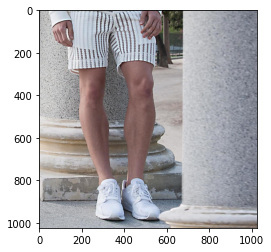

In [ ]:
img = plt.imread(f'./train/{name}')
img
plt.imshow(img)


In [ ]:
img.shape


(1024, 1024, 3)

In [ ]:
def new_format(coordinates):
  new_coordinates = []
  for x in range(0,(len(coordinates)/2)):
    tempX = coordinates[x]
    tempY = coordinates[x+1] 
    temp = (tempX,tempY)
    new_coordinates.append(temp)



SystemError: ignored

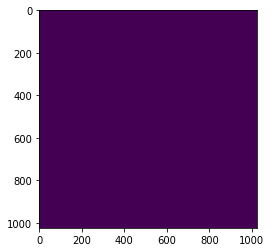

In [ ]:
base_mask = Image.new('L',(1024,1024),0)
plt.imshow(base_mask)
ImageDraw.Draw(base_mask).polygon(polygon,outline=1,fill=1)
mask = np.array(base_mask)

In [ ]:
TRAIN_PATH = './train'

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))

In [ ]:
train_ids

('./train',
 [],
 ['ae4865c4af0a7e87dd5c6a7304fe57d3.jpg',
  '045e3f121065c013bf40146676f04756.jpg',
  'a7f34be335db522200eca65b5160a6a0.jpg',
  '59272e017a9ebc112f3e93b1ab153974.jpg',
  'a8e7d12b5efc2135d8cd8dfad3bf52cd.jpg',
  'eb8322ef97eff6e825e10eb6878d597d.jpg',
  '660fdd694e827b716de91918b0eaebeb.jpg',
  'ba5c114e89a39d4b335b096b490be881.jpg',
  '6c6d5463c7ff200d7ed41d3e3f9ccb8e.jpg',
  '1753a81cef6a973fde3d0a97f0c17ac0.jpg',
  'acfeaf3a440c0b95811f20368c11fbc8.jpg',
  'd5de5626bf6be1ad8fea7e5fcde2087a.jpg',
  'dae5dfbd041819c8d8e507f5ccc5daf8.jpg',
  'eed2a73a4dc7506b1ce5042c0d86a41f.jpg',
  '9c3ac0c179d368d84b2de16bb42216a4.jpg',
  'ad686bcbc15476eb8f4a1b1802cce006.jpg',
  '5de754136785169fa3fa6e677867eb34.jpg',
  'b79dc811bd81a5aece47a2d439d04937.jpg',
  'ee7a219a1af3dd000677d8a5bb8c650a.jpg',
  '8bfab8db7ff18a5cc4f41fac5e69194c.jpg',
  'c76b636c1021039bea6726bf2f00be85.jpg',
  '1a9b091d53b39344bf39b989f02fb56f.jpg',
  '3954a0c5661dcfd6c82df816fb020633.jpg',
  'e118794c612922

##Note preprocessing 

In [ ]:
IMAGE_WIDTH = 124
IMAGE_HEIGHT = 124
IMAGE_CHANNELS = 3

In [ ]:
X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

NameError: ignored

In [ ]:
## resizing images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
    

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K





def model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   
  

    #Contraction 
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansion
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return 

In [ ]:
model()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_8 (Lambda)              (None, 256, 256, 1)  0           ['input_12[0][0]']               
                                                                                                  
 conv2d_164 (Conv2D)            (None, 256, 256, 16  160         ['lambda_8[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
#checkpoint 
checkpointer = tf.keras.callbacks.ModelCheckpoint('image-segmentation_for_opendata',verbose=1,save_best_only=True )
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logs_dir='./logs')
]
results = model.fit(X,Y,validation_split=0.1,batch_size=16,epochs=25,callbacks=callbacks)

SyntaxError: ignored